In [1]:
import json
import random

import contextily as cx
import geojson
import matplotlib.pyplot as plt
import shapely
import trajgenpy.Logging
from matplotlib.lines import lineStyles
from numpy import poly
from trajgenpy import Utils
from trajgenpy.Geometries import (
    GeoMultiPolygon,
    GeoMultiTrajectory,
    GeoPolygon,
    GeoTrajectory,
    decompose_polygon,
    generate_sweep_pattern,
    get_sweep_offset,
)
from trajgenpy.Query import query_features

log = trajgenpy.Logging.get_logger()



#### Helper functions

In [2]:
def get_line_segments(polygon: GeoPolygon):
    polygon_list = decompose_polygon(polygon.get_geometry())

    log.info(f"Number of polygons: {len(polygon_list)}")

    offset = get_sweep_offset(0.1, 15, 90)
    result = []
    for decomposed_poly in polygon_list:
        sweeps_connected = generate_sweep_pattern(
            decomposed_poly, offset, connect_sweeps=False
        )
        result.extend(sweeps_connected)
    return result


Load the geojson environmental file

In [3]:
polygon_file = "DemaScenarios/FlatTerrainNature.geojson"

# Load the GeoJSON data
with open(polygon_file, "r") as f:
    data = json.load(f)

# Extract the polygon coordinates
coordinates = data["features"][0]["geometry"]["coordinates"][0]

# Create the shapely Polygon object
polygon = GeoPolygon(shapely.Polygon(coordinates)).set_crs("EPSG:2197")

Extract the environmental feature with the specific tags

2024-09-16 14:34:29,977 - INFO - Extracted 12 features with the tags: {'natural': ['water', 'wetland']} (runpy.py:36)
2024-09-16 14:34:30,901 - INFO - Extracted 16 features with the tags: {'highway': ['service', 'track']} (runpy.py:36)
2024-09-16 14:34:32,559 - INFO - Number of polygons: 11 (runpy.py:4)


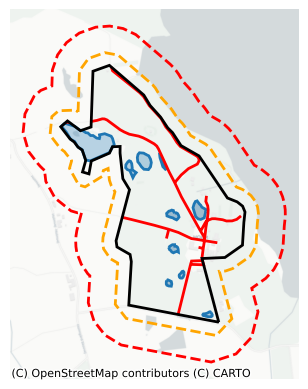

In [4]:

tags = {
    "natural": ["water", "wetland"],
}

wetland = query_features(
    GeoPolygon(shapely.Polygon(coordinates)),
    {
        "natural": ["water", "wetland"],
    },
)
for f in wetland.values():
    GeoMultiPolygon(f).set_crs("EPSG:2197").plot()

roads = query_features(
    GeoPolygon(shapely.Polygon(coordinates)),
    {
        "highway": ["service", "track"],
    },
)
for road in roads.values():
    GeoMultiTrajectory(road).set_crs("EPSG:2197").plot(color="red")


# multi_traj.plot(color="red", linestyle="dashed")

polygon.plot(facecolor="none", edgecolor="black", linewidth=2)
polygon.buffer(50).plot(
    facecolor="none",
    edgecolor="orange",
    linewidth=2,
    linestyle="dashed",
)

polygon.buffer(100).plot(
    facecolor="none",
    edgecolor="red",
    linewidth=2,
    linestyle="dashed",
)

Utils.plot_basemap(provider=cx.providers.CartoDB.Positron, crs="EPSG:2197")

# No axis on the plot
# plt.axis("equal")
plt.axis("off")
plt.show()